In [2]:
import urllib
from urllib import request
from bs4 import BeautifulSoup
import os
import requests
import argparse
import re
import time
import json
import math

import codecs
import urllib.parse as up

# Crawler and Semantic Scholar Information Extractor

In [3]:
# Generate a concatenated tldr string of papers from a certain query. Also return the information pack of these papers.
def SSSQuery(query, num_item=50, offset=0, fos=None):
    # Send a Semantic API post to get the result paper list
    query = '+'.join(query.split())
    url = f'https://api.semanticscholar.org/graph/v1/paper/search?query={query}&offset={offset}&limit={num_item}&fields=fieldsOfStudy,abstract'
    paper_list = str(request.urlopen(url).read(), 'utf-8')
    paper_list = json.loads(paper_list)

    tldr_cat = ''
    info_pack = []
    # Loop through the paper list and get information pack for each paper
    for paper in paper_list['data']:
        paper_id = paper['paperId']
        # Each paper info pack consists title, abstract, authors, tldr, citation count, field of study
        paper_url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=title,abstract,citations.authors,tldr,citationCount,fieldsOfStudy'
        paper_info = str(request.urlopen(paper_url).read(), 'utf-8')
        paper_info = json.loads(paper_info)
        # Filter out the papers out of field of study
        if fos is not None and fos not in paper_info['fieldsOfStudy']:
            continue
        info_pack.append(paper_info)
        tldr = paper_info['tldr']
        if tldr is not None:
            tldr_cat += ' '+tldr['text'].strip()
    tldr_cat = tldr_cat.strip()
    return tldr_cat, info_pack

In [4]:
tldr_cat, info_pack = SSSQuery('transformer', num_item=10, fos='Computer Science')
print([i['title'] for i in info_pack])

['Spatial Transformer Networks', 'Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer', 'Transformer-XL: Attentive Language Models beyond a Fixed-Length Context', 'Longformer: The Long-Document Transformer', 'Reformer: The Efficient Transformer', 'Conformer: Convolution-augmented Transformer for Speech Recognition', 'Heterogeneous Graph Transformer', 'AraBERT: Transformer-based Model for Arabic Language Understanding', 'Reducing Transformer Depth on Demand with Structured Dropout', 'Meshed-Memory Transformer for Image Captioning']


In [5]:
tldr_cat

'This work introduces a new learnable module, the Spatial Transformer, which explicitly allows the spatial manipulation of data within the network, and can be inserted into existing convolutional architectures, giving neural networks the ability to actively spatially transform feature maps. This systematic study compares pre-training objectives, architectures, unlabeled datasets, transfer approaches, and other factors on dozens of language understanding tasks and achieves state-of-the-art results on many benchmarks covering summarization, question answering, text classification, and more. This work proposes a novel neural architecture Transformer-XL that enables learning dependency beyond a fixed length without disrupting temporal coherence, which consists of a segment-level recurrence mechanism and a novel positional encoding scheme. Following prior work on long-sequence transformers, the Longformer is evaluated on character-level language modeling and achieves state-of-the-art result

# Keywords Extraction

In [6]:
language = "en"
max_ngram_size = 1
deduplication_thresold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 20

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(tldr_cat)
keywords = sorted(keywords, key=lambda x:x[1])
for kw in keywords:
    print(kw)

('Spatial', 0.03213113441634914)
('work', 0.04798022059872212)
('language', 0.06973861700167353)
('Transformer', 0.07994217878795795)
('tasks', 0.08425923835568348)
('architectures', 0.12034394262796394)
('Longformer', 0.1231255301810972)
('neural', 0.13795581464104506)
('training', 0.13840506098154778)
('module', 0.14654904914113015)
('giving', 0.14654904914113015)
('maps', 0.14654904914113015)
('achieves', 0.1514314025909243)
('results', 0.1514314025909243)
('introduces', 0.15751851687783422)
('learnable', 0.15751851687783422)
('explicitly', 0.15751851687783422)
('manipulation', 0.15751851687783422)
('data', 0.15751851687783422)
('inserted', 0.15751851687783422)


In [8]:
!pip install transformers==3.4.0

  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.12.5
    Uninstalling transformers-4.12.5:
      Successfully uninstalled transformers-4.12.5


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

sentence-transformers 2.1.0 requires tokenizers>=0.10.3, but you'll have tokenizers 0.9.2 which is incompatible.
sentence-transformers 2.1.0 requires transformers<5.0.0,>=4.6.0, but you'll have transformers 3.4.0 which is incompatible.
flair 0.7 requires sentencepiece<=0.1.91, but you'll have sentencepiece 0.1.96 which is incompatible.
flair 0.7 requires transformers<=3.5.1,>=3.5.0, but you'll have transformers 3.4.0 which is incompatible.


In [9]:
!pip install googletrans==3.1.0a0

  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16378 sha256=8f4674fbb2ff2330cfd0f3f712c9fbc3c1a2a456af2b81b32691b457dcf47c07
  Stored in directory: c:\users\minha\appdata\local\pip\cache\wheels\26\36\33\1ead496ea4484c4df14c9d148c9e2676a1a2d821bc88d4f453
  Created wheel for contextvars: filename=contextvars-2.4-py3-none-any.whl size=7669 sha256=b2a2d93abe5e6689dbaf5986aade223becdd5f970a8084efc26af3e07f21c5e2
  Stored in directory: c:\users\minha\appdata\local\pip\cache\wheels\41\11\53\911724983aa48deb94792432e14e518447212dd6c5477d49d3
Successfully built googletrans contextvars


In [15]:
pip install celery==4.4.2


Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install seqeval


Note: you may need to restart the kernel to use updated packages.
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16175 sha256=fdc9b5b4982ca8a2e5f11506fd1729be7df2837efc779ee1cbc9a4b236a857dc
  Stored in directory: c:\users\minha\appdata\local\pip\cache\wheels\39\29\36\1c4f7905c133e11748ca375960154964082d4fb03478323089
Successfully built seqeval


In [10]:
pip install conllu

Note: you may need to restart the kernel to use updated packages.


In [1]:
from helpers import tokenize_and_format, flat_accuracy
import torch
import pandas as pd

df = pd.read_csv('transformer_citation_top5.csv')
# df = pd.read_csv('tweets.csv')

df = df.sample(frac=1).reset_index(drop=True)

texts = df.text.values
labels = df.citationCount.values

# labels =np.log(labels)/np.log(labels.max())

# print(labels)
### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(texts)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.FloatTensor(labels)
# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Original:  The goal of the tutorial is to provide an introduction to variational methods for approximate inference, particularly mean field approximation and belief propagation, and a summary comparison of the two procedures, along with some intuition about which approach is appropriate when.
Token IDs: tensor([  101,  1996,  3125,  1997,  1996, 14924,  4818,  2003,  2000,  3073,
         2019,  4955,  2000,  8386,  2389,  4725,  2005, 15796, 28937,  1010,
         3391,  2812,  2492, 20167,  1998,  6772, 20594,  1010,  1998,  1037,
        12654,  7831,  1997,  1996,  2048,  8853,  1010,  2247,  2007,  2070,
        26406,  2055,  2029,  3921,  2003,  6413,  2043,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [2]:

total = len(df)

num_train = int(total * .6)
num_val = int(total * .2)
num_test = total - num_train - num_val

# make lists of 3-tuples (already shuffled the dataframe in cell above)

train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train)]
val_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train, num_val+num_train)]
test_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_val + num_train, total)]

train_text = [texts[i] for i in range(num_train)]
val_text = [texts[i] for i in range(num_train, num_val+num_train)]
test_text = [texts[i] for i in range(num_val + num_train, total)]

In [3]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
device = torch.device("cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
batch_size = 64
optimizer = AdamW(model.parameters(),
                  lr = 1e-4, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8
                  weight_decay = 0.01
                )
epochs = 50





In [5]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(val_set):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set)/batch_size) + 1

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs[0]#.loss
        logits = outputs[1]#.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches. We provide a function in 
        # helpers.py called flat_accuracy() that takes in predictions and labels
        # acc = flat_accuracy(logits, label_ids)       
        # total_eval_accuracy += acc
        # print(logits,label_ids)
        error = np.abs(logits.T-label_ids).sum()
    # Report the final accuracy for this validation run.
    avg_error = error / num_batches
    return avg_error 



In [6]:
import random

# training loop
log_train_loss = np.zeros(epochs)
log_train_error = np.zeros(epochs)
# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    # num_batches = int(len(train_set)/batch_size) + 1
    num_batches = int(len(train_set)/batch_size)

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]
      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
      # print(outputs)
      loss = outputs[0]#.loss
      logits = outputs[1]#.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    log_train_loss[epoch_i] = total_train_loss
    val_error = get_validation_performance(val_set)
    log_train_error[epoch_i] = val_error
    print(f"Validation accuracy: {val_error}")
    
# print("")
print("Training complete!")



======== Epoch 1 / 50 ========
Training...
Total loss: 10.682881295681
Validation accuracy: 8.310111045837402

======== Epoch 2 / 50 ========
Training...
Total loss: 7.308704733848572
Validation accuracy: 8.786028861999512

======== Epoch 3 / 50 ========
Training...
Total loss: 7.329700231552124
Validation accuracy: 8.484431266784668

======== Epoch 4 / 50 ========
Training...
Total loss: 7.0027270913124084
Validation accuracy: 8.383172988891602

======== Epoch 5 / 50 ========
Training...
Total loss: 6.830851852893829
Validation accuracy: 7.996756553649902

======== Epoch 6 / 50 ========
Training...
Total loss: 6.889522910118103
Validation accuracy: 8.716316223144531

======== Epoch 7 / 50 ========
Training...
Total loss: 5.281064689159393
Validation accuracy: 6.603281021118164

======== Epoch 8 / 50 ========
Training...
Total loss: 3.338749334216118
Validation accuracy: 7.178820610046387

======== Epoch 9 / 50 ========
Training...
Total loss: 2.17450387775898
Validation accuracy: 7.6

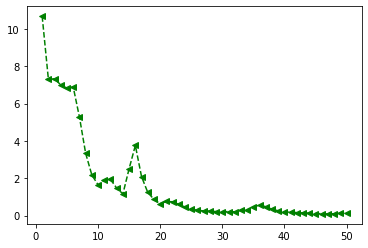

In [7]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,epochs+1)
# print(log_train_loss)
plt.plot(x,log_train_loss,linestyle='--',color='green',marker='<')
plt.show()

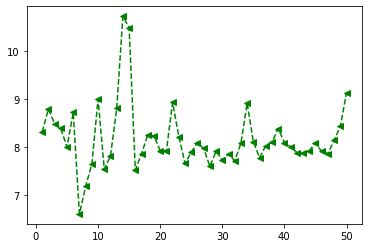

In [8]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,epochs+1)
# print(log_train_loss)
plt.plot(x,log_train_error,linestyle='--',color='green',marker='<')
plt.show()

In [9]:
import numpy as np
# function to get validation accuracy
def get_test_performance(val_set):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set)/batch_size) + 1

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs[0]#.loss
        logits = outputs[1]#.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches. We provide a function in 
        # helpers.py called flat_accuracy() that takes in predictions and labels
        # acc = flat_accuracy(logits, label_ids)       
        # total_eval_accuracy += acc
        # print(logits.T)
        # print(label_ids)
        print(np.abs(logits.T-label_ids).sum())
        error = np.abs(logits.T-label_ids).sum()
    # Report the final accuracy for this validation run.
    avg_error = error / num_batches
    return avg_error 

get_test_performance(val_set)

25.417408
45.786476
38.636177
36.503967


9.125991821289062

In [18]:
from keybert import KeyBERT

# doc = """
#          Supervised learning is the machine learning task of learning a function that
#          maps an input to an output based on example input-output pairs. It infers a
#          function from labeled training data consisting of a set of training examples.
#          In supervised learning, each example is a pair consisting of an input object
#          (typically a vector) and a desired output value (also called the supervisory signal). 
#          A supervised learning algorithm analyzes the training data and produces an inferred function, 
#          which can be used for mapping new examples. An optimal scenario will allow for the 
#          algorithm to correctly determine the class labels for unseen instances. This requires 
#          the learning algorithm to generalize from the training data to unseen situations in a 
#          'reasonable' way (see inductive bias).
#       """
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(tldr_cat, keyphrase_ngram_range=(1,3), stop_words='english', top_n = 10, use_maxsum=True, nr_candidates=40, use_mmr=True, diversity=0.7)
print(keywords)

[('neural architecture transformer', 0.5527), ('length disrupting', 0.1076), ('benchmarks covering summarization', 0.2611), ('language showed newly', 0.2474), ('explicitly allows spatial', 0.2433), ('replaces dot product', 0.2065), ('answering', 0.2506), ('finetune variety downstream', 0.0994), ('sampling algorithm hgsampling', -0.0439), ('nlp tasks layerdrop', 0.323)]


# Development Scratch

In [21]:
num_item = 30
offset = 0
query = 'hand'
query = '+'.join(query.split())
url = f'https://api.semanticscholar.org/graph/v1/paper/search?fos[0]=computer-science&query={query}&offset={offset}&limit={num_item}'
paper_list = str(request.urlopen(url).read(), 'utf-8')
paper_list = json.loads(paper_list)
# print(paper_list)

In [42]:
for paper in paper_list['data']:
    paper_id = paper['paperId']
    paper_url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=citations.authors,tldr,citationCount,fieldsOfStudy'
    paper_info = str(request.urlopen(paper_url).read(), 'utf-8')
    paper_info = json.loads(paper_info)
    print(paper_info['citationCount'], paper_info['fieldsOfStudy'])